# MLP para datos Reales

In [1]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import sys
import matplotlib
sns.set_style('darkgrid')
plt.style.use('ggplot')


# Manejo de fechas
import datetime
import matplotlib.dates as mdates
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn import metrics

pd.set_option('display.max_columns', None)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
#from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#from sklearn.externals import joblib
from sklearn.utils import resample

from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
#header_list=["cliente_id","no_documento","tipo_documento","nombre_completo_cliente","nombre_cliente","primer_apellido_cliente","segundo_apellido_cliente","email_cliente","tlf_principal","tlf_celular","tlf_domicilio","tlf_empresa","tlf_otro","fecha_nacimiento_cliente","genero_cliente","estado_civil_cliente","direccion_domicilio","empresa","direccion_empresa","cargo","profesion","fecha_ultima_actualizacion","fuente_ultima_actualizacion","ciudad_cliente","segmento_cliente","sueldo_cliente","tipo_empleado","cargas_familiares_cliente","nombre","fullDate","Tiempo","fase","gestion","tipo_gestion","subtipo_gestion","subtipo_gestion1","gestion_gxc_id","tipo_gestion_gxc_id","subtipo_gestion_gxc_id","categoria","fuente_gxc","gestion_gxc_estatus","tipo_gestion_gxc_estatus","subtipo_gestion_gxc_estatus","gestionado","contactado","contactabilidad_efectiva","ganada","perdida","no_perfil","indeciso","agente_id","usuario_agente","primer_apellido_agente","segundo_apellido","nombres_agente","cedula_agente","fecha_de_nacimiento_agente","edad_agente","estado_civil_agente","numero_de_hijos_agente","nivel_de_estudios_culminados_agente","celular_agente","correo_agente","direccion_agente","promedio_de_ingresos_agente"]

In [3]:

df1= pd.read_csv('../sintetic_ds.csv', sep=",")
df2= pd.read_csv('../sintetic_ds2.csv', sep=",")
df3= pd.read_csv('../datos_reales_finales_mlp.csv', sep=";")

df3.rename(columns={"N_SUPPLY": "N_supply", "Materia orgánica": "SOC", "pH":"PH"}, inplace=True)

df = pd.concat([df1,df2] , ignore_index=True)

#df= pd.read_csv('./sintetic_ds.csv', sep=";", header=None, names=header_list)
df.head()


errores_rmse=[]
df.head()

,PH,TEMP,SOC,KEX,PBRAY,N_base_supply,P_base_supply,K_base_supply,N_recovery,P_recovery,K_recovery,NrTrees,crop,NminStore,NminVeg,NmaxStore,NmaxVeg,PminStore,PminVeg,PmaxStore,PmaxVeg,KminStore,KminVeg,KmaxStore,KmaxVeg,Unnamed: 25,N,P,K,No,Po,Ko,leaf_att,stem_att,store_att,SeasonLength,leaf_lim,stem_lim,store_lim,N_supply,P_supply,K_supply,N_uptake,P_uptake,K_uptake,N_gap,P_gap,K_gap
0,4.7,21,30,1.5,1.1,63.8,1.7,21.2,0.7,0.17,0.7,3810,Coffee,0.0028,0.0454,0.0048,0.0459,0.00038,0.0038,0.00028,0.003,0.0045,0.003,0.0064,0.004,6779.22444,230,130,130,0,0,0,3264.08034,3515.1441,3713.394876,240,3264.1,3515.1,3152.1,212.1,22.5,105.8,195.8,22.0,97.8,159.3,10.7,0.0
1,5.7,21,20,1.7,1.1,67.5,5.3,29.2,0.7,0.17,0.7,5210,Coffee,0.0028,0.0454,0.0048,0.0459,0.00038,0.0038,0.00028,0.003,0.0045,0.003,0.0064,0.004,9270.27804,200,50,310,0,0,0,4463.47994,4806.7981,4262.349226,240,4463.5,4806.8,2881.2,207.1,13.8,245.8,175.7,13.7,138.4,331.8,112.6,0.0
2,5.1,21,21,1.5,1.1,55.1,3.7,28.0,0.7,0.17,0.7,3090,Coffee,0.0028,0.0454,0.0048,0.0459,0.00038,0.0038,0.00028,0.003,0.0045,0.003,0.0064,0.004,5498.11116,550,80,310,0,0,0,2647.24626,2850.8649,3386.065776,240,2647.2,2850.9,3185.0,375.9,14.8,209.2,265.1,14.8,139.2,0.0,29.6,0.0
3,5.9,21,25,0.3,1.1,90.6,6.8,3.9,0.7,0.17,0.7,4050,Coffee,0.0028,0.0454,0.0048,0.0459,0.00038,0.0038,0.00028,0.003,0.0045,0.003,0.0064,0.004,7206.26220,460,130,80,0,0,0,3469.69170,3736.5705,3815.710656,240,3469.7,3736.6,3285.6,397.7,27.9,57.7,292.9,25.2,57.0,0.0,0.0,0.0
4,5.3,21,10,1.1,1.1,28.8,2.4,41.4,0.7,0.17,0.7,6300,Coffee,0.0028,0.0454,0.0048,0.0459,0.00038,0.0038,0.00028,0.003,0.0045,0.003,0.0064,0.004,11209.74120,280,40,50,0,0,0,5397.29820,5812.4430,4609.717375,240,5397.3,5812.4,1784.7,209.6,8.6,71.2,150.7,8.6,58.9,456.6,182.7,0.0


In [4]:
df3.dropna(subset=['N_supply'], inplace=True)
df3

,Manejo,Nitratos,Amonio,Humedad,PH,SOC,N_supply
0,1.0,"92,230","0,496","15,480","5,000","4,885","92,726"
1,1.0,"91,060","0,402","15,480","5,060","4,882","91,462"
2,1.0,"90,480","0,440","17,910","5,020","4,888","90,920"
3,1.0,"185,040","0,274","16,040","4,590","3,826","185,314"
4,1.0,"216,980","0,120","14,640","4,660","3,824","217,100"
...,...,...,...,...,...,...,...
103,2.0,"22,440","0,519","10,600","4,870","1,278","22,959"
104,2.0,"21,620","0,508","10,270","4,750","1,274","22,128"
105,2.0,"26,390","0,415","11,120","5,240","1,111","26,805"
106,2.0,"26,260","0,338","11,060","5,270","1,112","26,598"


In [5]:
TO_KEEP=['PH', 'SOC','N_supply']
#TO_KEEP=['PH', 'SOC', 'KEX', 'PBRAY', 'N', 'P', 'K', 'N_supply']
df = df[TO_KEEP]
df3 = df3[TO_KEEP]
df


,PH,SOC,N_supply
0,4.7,30,212.1
1,5.7,20,207.1
2,5.1,21,375.9
3,5.9,25,397.7
4,5.3,10,209.6
...,...,...,...
14995,4.7,22,441.6
14996,5.3,26,421.9
14997,5.6,34,479.9
14998,4.7,15,471.3


In [6]:
df.count()

PH          15000
SOC         15000
N_supply    15000
dtype: int64

In [7]:
df3

,PH,SOC,N_supply
0,"5,000","4,885","92,726"
1,"5,060","4,882","91,462"
2,"5,020","4,888","90,920"
3,"4,590","3,826","185,314"
4,"4,660","3,824","217,100"
...,...,...,...
103,"4,870","1,278","22,959"
104,"4,750","1,274","22,128"
105,"5,240","1,111","26,805"
106,"5,270","1,112","26,598"


## Escogiendo columnas relevantes

In [8]:
df.value_counts()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PH        15000 non-null  float64
 1   SOC       15000 non-null  int64  
 2   N_supply  15000 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 351.7 KB


In [9]:
y = df['N_supply']
X = df.drop('N_supply', axis=1)
X.info()

ytest_new_dataset=df3['N_supply']
Xtest_new_dataset=df3.drop('N_supply', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.3, random_state = 0)



gt = y_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PH      15000 non-null  float64
 1   SOC     15000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 234.5 KB


## Multi-layer Perceptron (MLP)

In [10]:

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
pred = regr.predict(X_test)



print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
errores_rmse.append(np.sqrt(metrics.mean_squared_error(gt, pred)))
mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('R^2:', metrics.r2_score(gt, pred))

regr.score(X_test, y_test)




Mean Absolute Error (MAE): 93.96453527451426
Mean Squared Error (MSE): 12182.04394467069
Root Mean Squared Error (RMSE): 110.37229699825355
Mean Absolute Percentage Error (MAPE): 34.2
Accuracy: 65.8
R^2: 0.03699123575800212


0.03699123575800212

In [11]:
X_test.head()


,PH,SOC
1670,5.5,13
13379,4.7,19
10234,5.9,14
4719,5.1,33
7003,5.8,34


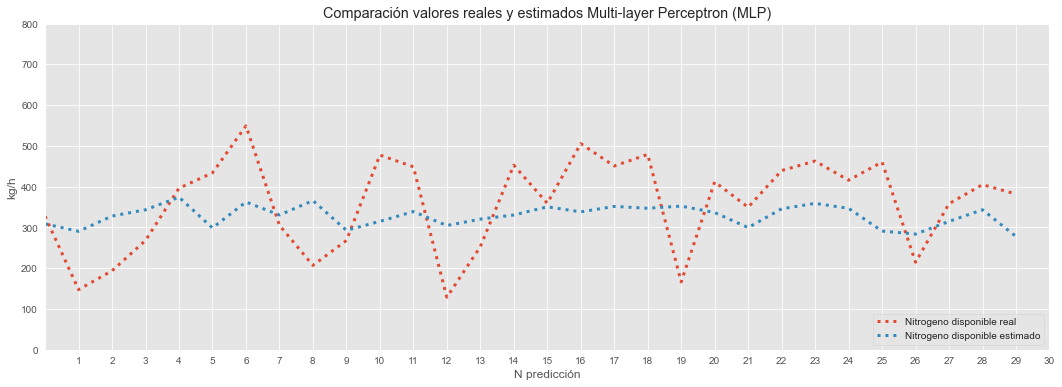

In [12]:
muestras = 30
lw = 3

y_points = np.array(gt[:muestras])
p_points = np.array(pred[:muestras])
plt.rcParams["figure.figsize"] = (18, 6)
plt.plot(y_points, ls = ':', label='Nitrogeno disponible real', lw=lw)
plt.plot(p_points, ls = ':', label='Nitrogeno disponible estimado', lw=lw)
lst = list(range(1,muestras+1))
plt.xticks(lst)
plt.xlim([0, muestras])
plt.ylim([0, 800])
plt.xlabel('N predicción')
plt.ylabel('kg/h')
plt.title('Comparación valores reales y estimados Multi-layer Perceptron (MLP)')
plt.legend(loc='lower right')
plt.show()




In [13]:
errores_rmse

[110.37229699825355]